# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import datetime
import re
import matplotlib.pyplot as plt
from pprint import pprint


# Load Data

In [ ]:
sub_files = glob('../../../Data/*/*.xdf')
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

In [3]:
# Load data for each participant
all_data = {}
for pt_number in range(len(sub_files)): 
    xdf_path = sub_files[pt_number]
    data, header = pyxdf.load_xdf(xdf_path)
    all_data[pt_number] = data


In [4]:
# get et_df and sub_names
all_et_dfs = {}
sub_names = {}
for pt_number in range(len(sub_files)): 
    sub_names[pt_number] = sub_files[pt_number].split('/')[3].split('-')[1]
    streams_collected = [stream['info']['name'][0] for stream in all_data[pt_number]]

    # ET data
    ET = all_data[pt_number][streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

    # make et_df
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)
    et_df['lsl_time_stamp'] = ET['time_stamps']
    all_et_dfs[pt_number] = et_df

# hist of euclidian distances between left and right eye gaze points

In [152]:
def gaze_point_histogram(pt_number, ax):
    # remove nans
    et_nums = all_et_dfs[pt_number][~np.isnan(all_et_dfs[pt_number].left_gaze_point_on_display_area_0) &
        ~np.isnan(all_et_dfs[pt_number].left_gaze_point_on_display_area_1) &
        ~np.isnan(all_et_dfs[pt_number].right_gaze_point_on_display_area_0) &
        ~np.isnan(all_et_dfs[pt_number].right_gaze_point_on_display_area_1)]
    
    # euclid distance 
    x1 = et_nums.right_gaze_point_on_display_area_0
    x2 = et_nums.left_gaze_point_on_display_area_0
    y1 = et_nums.right_gaze_point_on_display_area_1
    y2 = et_nums.left_gaze_point_on_display_area_1
    dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # return vars
    sub_name = sub_names[pt_number] #sub_files[pt_number].split('/')[3].split('-')[1]
    dmax = np.nanmax(dists)
    nsamp = int(ET['footer']['info']['sample_count'][0])
    srate = round(ET['info']['effective_srate'], 4)
    over02 = round(sum(dists >= 0.2)/len(dists) * 100, 2) # percent of non-NaN data w distance over 0.2

    # plot
    if ax is None:
        fig, ax = plt.subplots()

    ax.hist(dists, bins =75, alpha = 0.6, label = sub_name)
    ax.set_title(f'Distribution of Distances Between \nLeft and Right Gaze Points for Subject {sub_name}')
    ax.set_xlabel('Distance between L + R Gaze Points')
    ax.set_ylabel('Count')

    return sub_name, dmax, nsamp, srate, over02, ax



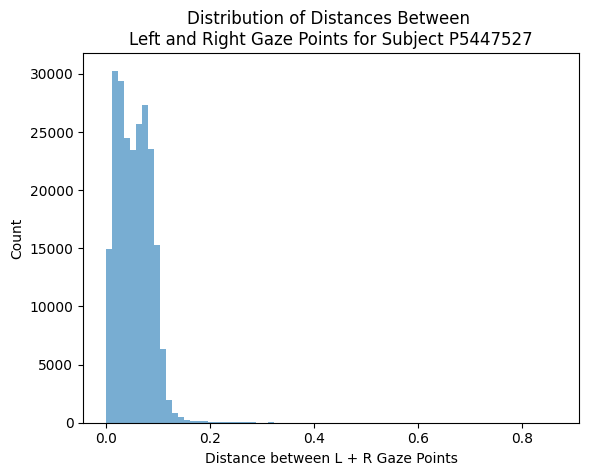

In [153]:
# run for just one subject
gaze_point_histogram(2, None)
plt.show()

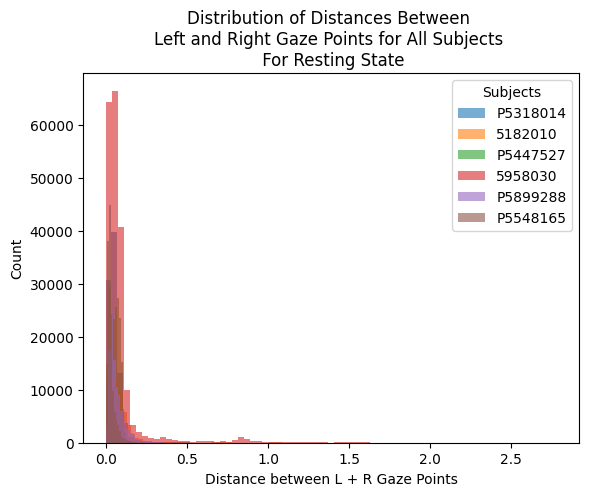

In [154]:
fig, ax1 = plt.subplots()
results1 = []

for i in range(len(sub_files)):
    sub_name, dmax, nsamp, srate, over02, _ = gaze_point_histogram(i, ax=ax1)  # Pass shared axes
    results1.append({'input': i, 'sub_id': sub_name, 'dmax': dmax, 'nsamp': nsamp, 'srate': srate, 'over02': over02})

ax1.legend(title = 'Subjects')
ax1.set_title('Distribution of Distances Between \nLeft and Right Gaze Points for All Subjects \n For Resting State')
plt.show()

In [155]:
pprint(results1, width = 200, sort_dicts = False)

[{'input': 0, 'sub_id': 'P5318014', 'dmax': 2.601616, 'nsamp': 187767, 'srate': 119.996, 'over02': 1.6},
 {'input': 1, 'sub_id': '5182010', 'dmax': 1.939446, 'nsamp': 187767, 'srate': 119.996, 'over02': 6.93},
 {'input': 2, 'sub_id': 'P5447527', 'dmax': 0.86599404, 'nsamp': 187767, 'srate': 119.996, 'over02': 0.3},
 {'input': 3, 'sub_id': '5958030', 'dmax': 2.7787168, 'nsamp': 187767, 'srate': 119.996, 'over02': 7.08},
 {'input': 4, 'sub_id': 'P5899288', 'dmax': 1.1290684, 'nsamp': 187767, 'srate': 119.996, 'over02': 1.92},
 {'input': 5, 'sub_id': 'P5548165', 'dmax': 0.7700742, 'nsamp': 187767, 'srate': 119.996, 'over02': 0.12}]


# Line plots- gaze point difference over time



## Distance between gaze points over time

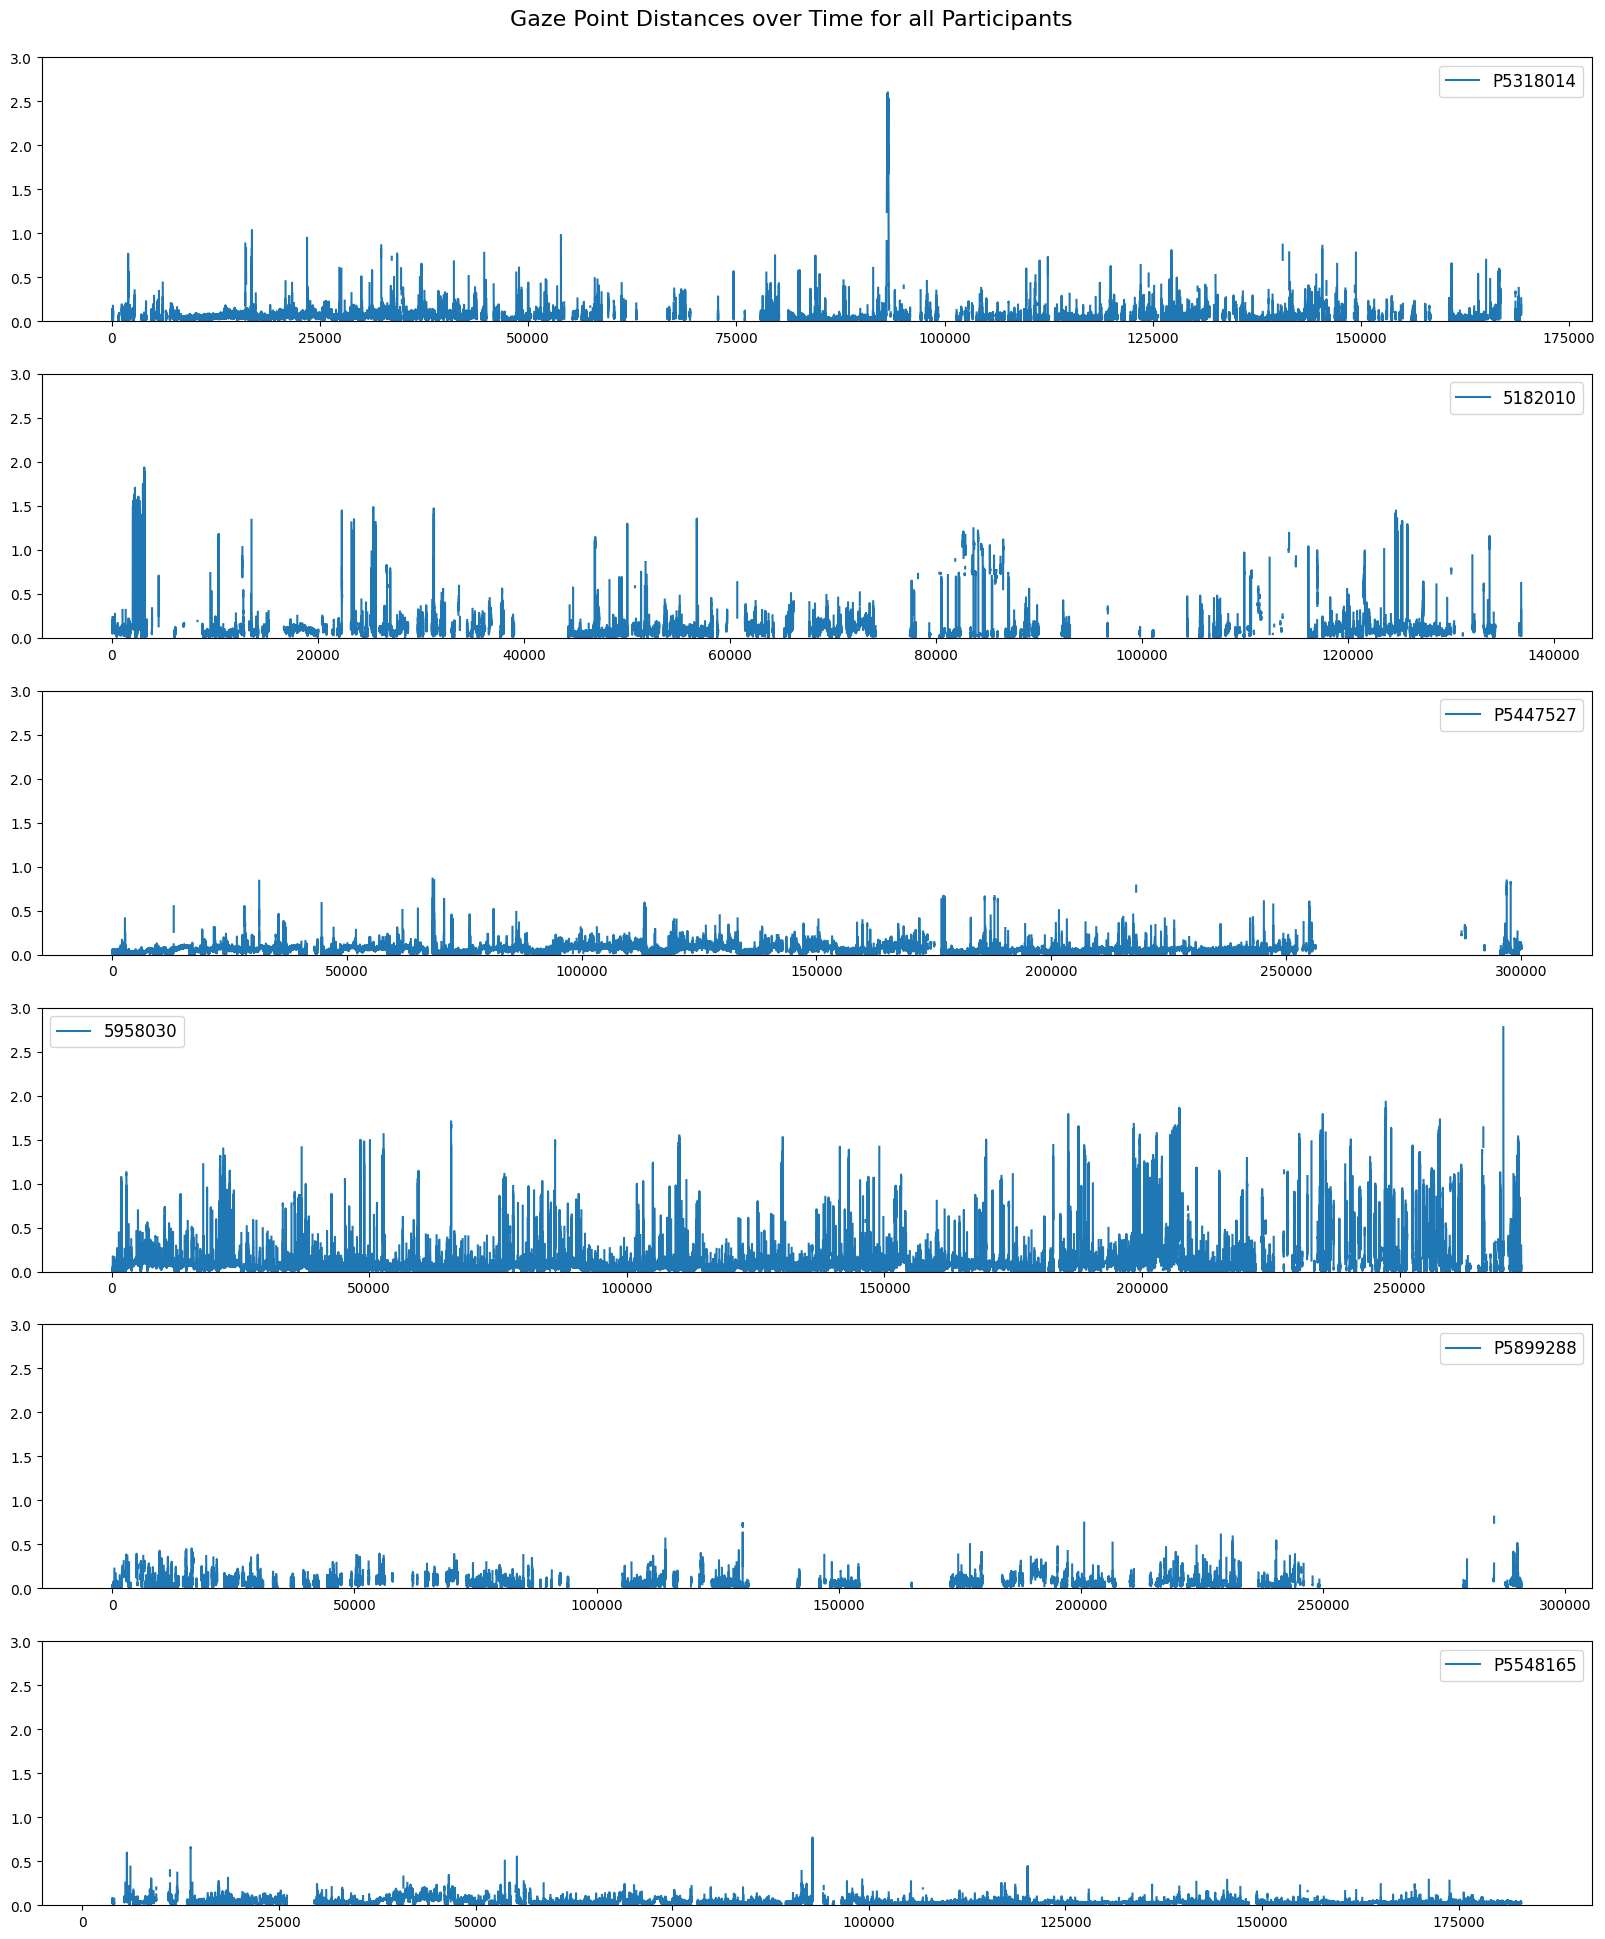

In [ ]:
# different axes 
fig, ax = plt.subplots(figsize=(20,24), nrows=len(sub_files), ncols=1)

for i in range(6):
    x1 = all_et_dfs[i].right_gaze_point_on_display_area_0
    x2 = all_et_dfs[i].left_gaze_point_on_display_area_0
    y1 = all_et_dfs[i].right_gaze_point_on_display_area_1
    y2 = all_et_dfs[i].left_gaze_point_on_display_area_1
    dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    ax[i].plot(dists, label = sub_names[i])
    ax[i].set_ylim(0, 3)
    # ax[i].set_xlim(0, 310000)
    ax[i].legend(fontsize = 'large')

fig.suptitle("Gaze Point Distances over Time for All Participants", y = .9, fontsize = 16)
plt.show()

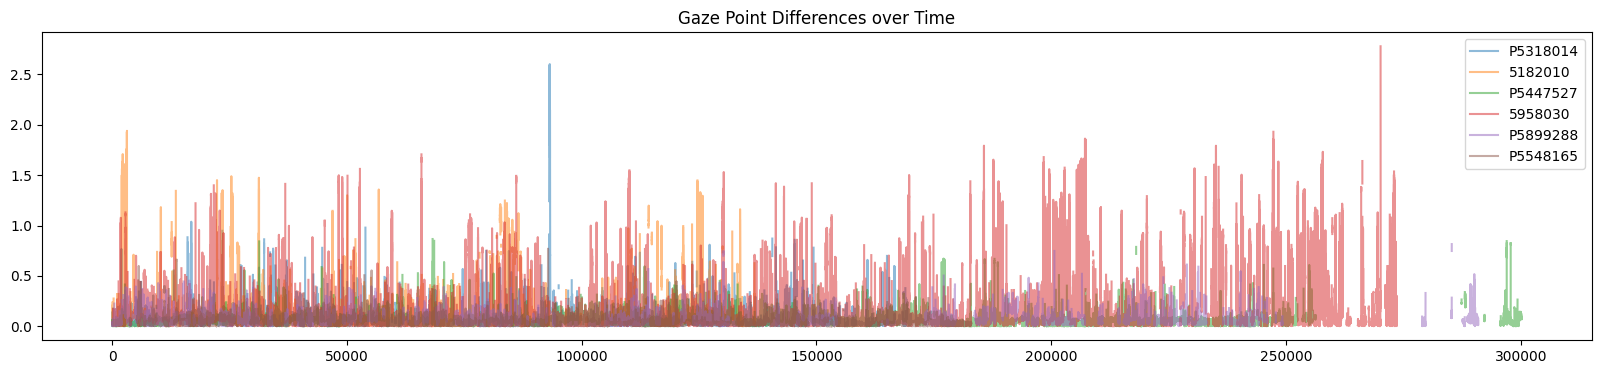

In [158]:
# shared axes 
fig = plt.figure(figsize = (20, 4))
for i in range(6):
    x1 = all_et_dfs[i].right_gaze_point_on_display_area_0
    x2 = all_et_dfs[i].left_gaze_point_on_display_area_0
    y1 = all_et_dfs[i].right_gaze_point_on_display_area_1
    y2 = all_et_dfs[i].left_gaze_point_on_display_area_1
    dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    plt.plot(dists, alpha = 0.5, label = sub_names[i])
plt.title("Gaze Point Differences over Time")
plt.legend()
plt.show()